In [2]:
import torch
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.dataset import Dataset, TensorDataset
from torch.utils.data.dataloader import DataLoader
import json
import pickle
import string
from DiacriticDataset import DiacriticDataset
from DiacriticDataset import DiacriticDatasetShaddah
import pyarabic.araby as araby
import pyarabic.number as number
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
train_dataset = DiacriticDatasetShaddah('Dataset_with_shaddah/train_cleaned_withshadda_215.txt','Dataset_with_shaddah/letter_to_id.pickle','Dataset_with_shaddah/id_to_letter.pickle','Dataset_with_shaddah/diacritic_to_id.pickle','Dataset_with_shaddah/id_to_diacritic.pickle','Dataset_with_shaddah/word_to_id.pickle','Dataset_with_shaddah/id_to_word.pickle','Dataset/diacritic_to_id.pickle','Dataset/id_to_diacritic.pickle')
test_dataset = DiacriticDatasetShaddah('Dataset_with_shaddah/test_cleaned_withshadda_215.txt','Dataset_with_shaddah/letter_to_id.pickle','Dataset_with_shaddah/id_to_letter.pickle','Dataset_with_shaddah/diacritic_to_id.pickle','Dataset_with_shaddah/id_to_diacritic.pickle','Dataset_with_shaddah/word_to_id.pickle','Dataset_with_shaddah/id_to_word.pickle','Dataset/diacritic_to_id.pickle','Dataset/id_to_diacritic.pickle')
val_dataset = DiacriticDatasetShaddah('Dataset_with_shaddah/val_cleaned_withshadda_215.txt','Dataset_with_shaddah/letter_to_id.pickle','Dataset_with_shaddah/id_to_letter.pickle','Dataset_with_shaddah/diacritic_to_id.pickle','Dataset_with_shaddah/id_to_diacritic.pickle','Dataset_with_shaddah/word_to_id.pickle','Dataset_with_shaddah/id_to_word.pickle','Dataset/diacritic_to_id.pickle','Dataset/id_to_diacritic.pickle')

In [4]:
train_dataloader = DataLoader(train_dataset)
test_dataloader = DataLoader(test_dataset)
val_dataloader = DataLoader(val_dataset)

In [5]:
class AutoDiacriticNet(nn.Module):
    def __init__(self,word_emb_dim, hidden_dim, letter_vocab_size,diacritic_vocab_size,word_vocab_size):
        super(AutoDiacriticNet, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.letter_embedding = nn.Embedding(letter_vocab_size, word_emb_dim)
        self.lstm = nn.LSTM(input_size=word_emb_dim,hidden_size=hidden_dim,num_layers=2,bidirectional=True,batch_first=True)
        self.linear1 = nn.Linear(in_features=2*hidden_dim,out_features=2*hidden_dim)
        self.linear2 = nn.Linear(in_features=2*hidden_dim,out_features=2*hidden_dim)
        self.output = nn.Linear(in_features=2*hidden_dim,out_features=diacritic_vocab_size)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax()
        
    def forward(self,letters,words):
        model_input = letters.to(self.device)
        embedded = self.letter_embedding(model_input)
        lstm_out, _ = self.lstm(embedded)
        linear1_out = self.relu(self.linear1(lstm_out.view(letters.size()[1],-1)))
        linear2_out = self.relu(self.linear2(linear1_out))
        output = self.softmax(self.output(linear2_out))
        return output
        

In [6]:
EPOCHS = 5
LETTER_EMBEDDING_DIM = 5
HIDDEN_DIM = 256

letter_vocab_size = len(train_dataset.letter_to_id)
diacritic_vocab_size = len(train_dataset.diacritic_to_id)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

model = AutoDiacriticNet(LETTER_EMBEDDING_DIM,HIDDEN_DIM,letter_vocab_size,diacritic_vocab_size,None)
model.load_state_dict(torch.load('Models/BasicNN_Shaddah'))

if use_cuda:
    model.cuda()
    
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
acumulate_grad_steps = 64

In [7]:
def eval_test():
    predictions = []
    true_labels = []
    true_prediction = 0
    total = 0
    for batch_idx, input_data in enumerate(test_dataloader):

        letters = input_data[0]
        diacritics = input_data[1]
        labels = diacritics[0].to(model.device)
        probs = model(letters,None)
        _, predicted = torch.max(probs.data, 1)
        true_prediction += ((predicted==labels).sum()).item()
        total += letters.size()[1]
        
        predictions += predicted.tolist()
        true_labels += labels.tolist()
        
    Accuracy = true_prediction/total
    return Accuracy,predictions,true_labels

    

In [8]:
def eval_validation():
    predictions = []
    true_labels = []
    true_prediction = 0
    total = 0
    for batch_idx, input_data in enumerate(val_dataloader):

        letters = input_data[0]
        diacritics = input_data[1]
        labels = diacritics[0].to(model.device)
        probs = model(letters,None)
        _, predicted = torch.max(probs.data, 1)
        true_prediction += ((predicted==labels).sum()).item()
        total += letters.size()[1]
        
        predictions += predicted.tolist()
        true_labels += labels.tolist()
        
    Accuracy = true_prediction/total
    return Accuracy,predictions,true_labels


In [9]:
def test_word_accuracy():
    true_prediction = 0
    total = 0
    wrong_words = []
    for batch_idx, input_data in enumerate(test_dataloader):

        letters = input_data[0]
        diacritics = input_data[1]
        labels = diacritics[0].to(model.device)
        probs = model(letters,None)
        _, predicted = torch.max(probs.data, 1)
        sentence = ''

        for index,letter_id in enumerate(letters[0]):
            letter = train_dataset.id_to_letter[letter_id.item()]
            diacritic = train_dataset.id_to_diacritic[predicted[index].item()]
            if letter_id==2:
                sentence += " "
                diacritic = ""
            elif predicted[index] == 3: 
                diacritic = ""

            sentence += (letter+diacritic)


        true_words = input_data[4][0]
        predicted_words = sentence.split()

        for index,predicted_word in enumerate(predicted_words):
            predicted_word_id = train_dataset.word_to_id.get(predicted_word,'NOT_FOUND')
            if predicted_word_id != 'NOT_FOUND':
                if predicted_word_id == true_words[index]:
                    true_prediction += 1
                else:
                    wrong_words.append(train_dataset.id_to_word[true_words[index].item()])
            else:
                wrong_words.append(train_dataset.id_to_word[true_words[index].item()])
                continue


        total += len(predicted_words)



    word_accuracy = true_prediction/total
    return word_accuracy

In [9]:
loss_list_train = []
for epoch in range(EPOCHS):
    loss_train_total = 0
    i = 0
    for batch_idx, input_data in enumerate(train_dataloader):           
        i += 1
        letters = input_data[0]
        diacritics = input_data[1]
        labels = diacritics[0].to(model.device)
        probs = model(letters,None)
        loss = criterion(probs,labels)
        loss = loss/ acumulate_grad_steps
        loss.backward()
        
        if i % acumulate_grad_steps == 0:
            optimizer.step()
            model.zero_grad()
        
        loss_train_total += loss.item()
            
    
    loss_train_total = loss_train_total / len(train_dataset)
    loss_list_train.append(float(loss_train_total))
    e_interval = i
    val_accuracy,_,_ = eval_validation()
    print("Epoch {} Completed,\tTrain Loss: {}\tValidation Diacritic Accuracy: {:.3f}".format(epoch + 1, np.mean(loss_list_train[-e_interval:]),val_accuracy))

/anaconda/envs/project/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1 Completed,	Train Loss: 0.011260789827823916	Test Diacritic Accuracy: 0.889
Epoch 2 Completed,	Train Loss: 0.007708352857035713	Test Diacritic Accuracy: 0.927
Epoch 3 Completed,	Train Loss: 0.006153880460195594	Test Diacritic Accuracy: 0.942
Epoch 4 Completed,	Train Loss: 0.005229200825163085	Test Diacritic Accuracy: 0.948
Epoch 5 Completed,	Train Loss: 0.004595394587169435	Test Diacritic Accuracy: 0.952


In [ ]:
torch.save(model.state_dict(), 'Models/BasicNN_Shaddah')

In [10]:
diacritic_accuracy,predictions,true = eval_test()
word_accuracy = test_word_accuracy()
print("Test Diacritic Accuracy: {:.3f}\tTest Word Accuracy: {:3f}".format(diacritic_accuracy,word_accuracy))

/anaconda/envs/project/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test Diacritic Accuracy: 0.951	Test Word Accuracy: 0.823813


In [7]:
true_shaddah = 0
total_wordswithshadda = 0
true_noshaddah = 0
total_wordswithnoshadda = 0
for batch_idx, input_data in enumerate(test_dataloader):
        
    letters = input_data[0]
    diacritics = input_data[1]
    labels = diacritics[0].to(model.device)
    probs = model(letters,None)
    _, predicted = torch.max(probs.data, 1)
    sentence = ''

    for index,letter_id in enumerate(letters[0]):
        letter = train_dataset.id_to_letter[letter_id.item()]
        diacritic = train_dataset.id_to_diacritic[predicted[index].item()]
        if letter_id==2:
            sentence += " "
            diacritic = ""
        elif predicted[index] == 3: 
            diacritic = ""

        sentence += (letter+diacritic)
    
        
    true_words = input_data[2][0]
    predicted_words = sentence.split()

    for index,predicted_word in enumerate(predicted_words):
        predicted_word_id = train_dataset.word_to_id.get(predicted_word,'NOT_FOUND')
        true_word = train_dataset.id_to_word[true_words[index].item()]
        if araby.strip_shadda(true_word) != true_word: 
            if predicted_word_id != 'NOT_FOUND':
                if predicted_word_id == true_words[index]:
                    true_shaddah+= 1
                    
            total_wordswithshadda += 1
            
        else:
            if predicted_word_id != 'NOT_FOUND':
                if predicted_word_id == true_words[index]:
                    true_noshaddah+= 1           
            total_wordswithnoshadda += 1
    
    
percentage_shadda = true_shaddah/total_wordswithshadda
percentage_noshadda = true_noshaddah/total_wordswithnoshadda
print("Percentage of correctly classified words with shaddah: ",percentage_shadda)
print("Percentage of correctly classified words without shaddah: ",percentage_noshadda)


/anaconda/envs/project/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Percentage of correctly classified words with shaddah:  0.7684287543442473
Percentage of correctly classified words without shaddah:  0.836570465557194


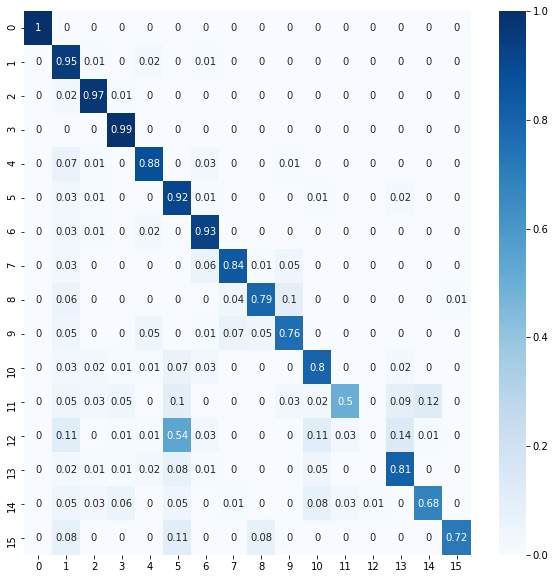

In [11]:
plt.figure(figsize=(10, 10))

cm  = confusion_matrix(true,predictions,normalize='true').round(2)

f = sns.heatmap(cm, annot=True,cmap='Blues')

In [12]:
for i in np.diag(cm):
    print(i)
    


1.0
0.95
0.97
0.99
0.88
0.92
0.93
0.84
0.79
0.76
0.8
0.5
0.0
0.81
0.68
0.72
